# Tutorial 03 — MNIST Classification with SOEN

This notebook demonstrates training a SOEN (Superconducting Optoelectronic Network) model on the MNIST digit classification task.

---

## 🔊 NOISE CONFIGURATION: ENABLED (Default)

> **This tutorial runs with NOISE INJECTION by default (documented values).**
>
> | Parameter | Default | Description |
> |-----------|---------|-------------|
> | `phi` | **0.01** | Noise on input flux |
> | `s` | **0.005** | Noise on state |
> | `relative` | **false** | Absolute scaling |
>
> **To toggle noise on/off**, use the `NOISE_ENABLED` setting in the Configuration cell below.

---

## Key Concepts

1. **Sequential Processing**: MNIST images (28×28) are treated as 28-timestep sequences, where each timestep is a row of 28 pixels
2. **Temporal Dynamics**: The SingleDendrite layer integrates information over time, leveraging SOEN's natural temporal processing
3. **Learnable Readout**: The output connection is learnable (lesson from Tutorial 02)

## Architecture

```
Input (28D) → SingleDendrite (128D) → Output (10D)
     ↓              ↓ ↺                   ↓
  Row pixels    Recurrent SOEN      10 digit classes
```

## Setup

In [1]:
# Disable tqdm notebook widgets BEFORE any imports
import os
os.environ["TQDM_DISABLE"] = "0"  # Don't disable, but force text mode
os.environ["TQDM_MININTERVAL"] = "1"

# Setup: Ensure soen_toolkit is importable
import sys
from pathlib import Path

# Add src directory to path if running from notebook location
notebook_dir = Path.cwd()
for parent in [notebook_dir] + list(notebook_dir.parents):
    candidate = parent / "src"
    if (candidate / "soen_toolkit").exists():
        sys.path.insert(0, str(candidate))
        break

import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn as nn
import glob
import gzip
import urllib.request
import struct

# Use standard tqdm (not notebook version to avoid widget errors)
try:
    from tqdm import tqdm
except ImportError:
    # Simple fallback if tqdm not available
    def tqdm(iterable, **kwargs):
        return iterable

# Set torch precision for H100 tensor cores
torch.set_float32_matmul_precision('high')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA device: NVIDIA H100 80GB HBM3


In [2]:
# ============================================================================
# NOISE CONFIGURATION TOGGLE
# ============================================================================
# Set NOISE_ENABLED to control noise injection:
#   True  = Noise enabled (default) - adds stochastic noise per timestep
#   False = Ideal conditions - no noise, deterministic behavior
# ============================================================================

NOISE_ENABLED = True  # Toggle this to enable/disable noise

# Default noise values from documentation (used when NOISE_ENABLED = True)
NOISE_DEFAULTS = {
    "phi": 0.01,           # Noise on input flux
    "s": 0.005,            # Noise on state
    "g": 0.0,              # Source function noise
    "bias_current": 0.0,   # Bias current noise
    "j": 0.0,              # Connection weight noise
    "relative": False,     # Absolute scaling
}

def set_model_noise(model, enabled=True, noise_values=None):
    """
    Toggle noise injection on/off for a SOEN model.
    
    Args:
        model: SOENModelCore instance
        enabled: True to enable noise, False to disable
        noise_values: Optional dict of noise values (uses NOISE_DEFAULTS if None)
    
    Returns:
        model: The modified model (in-place modification)
    """
    from soen_toolkit.core.configs import NoiseConfig
    
    if noise_values is None:
        noise_values = NOISE_DEFAULTS
    
    for cfg in model.layers_config:
        if enabled:
            # Apply noise values
            cfg.noise = NoiseConfig(
                phi=noise_values.get("phi", 0.01),
                s=noise_values.get("s", 0.005),
                g=noise_values.get("g", 0.0),
                bias_current=noise_values.get("bias_current", 0.0),
                j=noise_values.get("j", 0.0),
                relative=noise_values.get("relative", False),
                extras=getattr(cfg.noise, "extras", {}),
            )
        else:
            # Disable noise (all zeros)
            cfg.noise = NoiseConfig(
                phi=0.0, s=0.0, g=0.0, bias_current=0.0, j=0.0,
                relative=False,
                extras=getattr(cfg.noise, "extras", {}),
            )
    
    # Also update connection noise
    for conn_cfg in model.connections_config:
        if enabled:
            conn_cfg.noise = NoiseConfig(
                phi=0.0, g=0.0, s=0.0, bias_current=0.0,
                j=noise_values.get("j", 0.0),
                relative=noise_values.get("relative", False),
                extras={},
            )
        else:
            conn_cfg.noise = NoiseConfig(
                phi=0.0, g=0.0, s=0.0, bias_current=0.0, j=0.0,
                relative=False, extras={},
            )
    
    status = "ENABLED" if enabled else "DISABLED"
    print(f"✓ Noise injection {status}")
    if enabled:
        print(f"  phi={noise_values['phi']}, s={noise_values['s']}")
    
    return model

print(f"Noise configuration: {'ENABLED' if NOISE_ENABLED else 'DISABLED'}")

Noise configuration: ENABLED


## 1. Prepare MNIST Dataset

We'll download MNIST and convert it to HDF5 format compatible with the SOEN training pipeline.

**Data format**: Images are reshaped from (28, 28) to (28, 28) sequences where:
- Time dimension = 28 (rows)
- Feature dimension = 28 (columns/pixels per row)

In [3]:
def download_mnist_file(filename, base_url="https://ossci-datasets.s3.amazonaws.com/mnist/"):
    """Download a single MNIST file if not already present."""
    data_dir = Path("./data/mnist")
    data_dir.mkdir(parents=True, exist_ok=True)
    
    filepath = data_dir / filename
    if not filepath.exists():
        url = base_url + filename
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
    return filepath

def read_mnist_images(filepath):
    """Read MNIST image file (idx3-ubyte format)."""
    with gzip.open(filepath, 'rb') as f:
        # Read magic number and dimensions
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        # Read image data
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)
    return images

def read_mnist_labels(filepath):
    """Read MNIST label file (idx1-ubyte format)."""
    with gzip.open(filepath, 'rb') as f:
        # Read magic number and count
        magic, num_labels = struct.unpack('>II', f.read(8))
        # Read labels
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

def prepare_mnist_hdf5(output_path="training/datasets/mnist_seq28.hdf5", 
                       normalize=True,
                       val_split=0.1):
    """Download MNIST and save as HDF5 for SOEN training.
    
    Args:
        output_path: Where to save the HDF5 file
        normalize: Whether to normalize pixel values to [0, 1]
        val_split: Fraction of training data to use for validation
    """
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Check if already exists
    if output_path.exists():
        print(f"Dataset already exists at {output_path}")
        with h5py.File(output_path, 'r') as f:
            print(f"  Train samples: {len(f['train']['labels'])}")
            print(f"  Val samples: {len(f['val']['labels'])}")
            print(f"  Test samples: {len(f['test']['labels'])}")
        return output_path
    
    print("Downloading MNIST (without torchvision)...")
    
    # Download MNIST files
    train_images_file = download_mnist_file("train-images-idx3-ubyte.gz")
    train_labels_file = download_mnist_file("train-labels-idx1-ubyte.gz")
    test_images_file = download_mnist_file("t10k-images-idx3-ubyte.gz")
    test_labels_file = download_mnist_file("t10k-labels-idx1-ubyte.gz")
    
    # Read the data
    train_images = read_mnist_images(train_images_file).astype(np.float32)
    train_labels = read_mnist_labels(train_labels_file).astype(np.int64)
    test_images = read_mnist_images(test_images_file).astype(np.float32)
    test_labels = read_mnist_labels(test_labels_file).astype(np.int64)
    
    # Normalize to [0, 1]
    if normalize:
        train_images = train_images / 255.0
        test_images = test_images / 255.0
    
    # Split training into train/val
    n_train = len(train_images)
    n_val = int(n_train * val_split)
    
    # Shuffle before splitting
    np.random.seed(42)
    indices = np.random.permutation(n_train)
    val_indices = indices[:n_val]
    train_indices = indices[n_val:]
    
    val_images = train_images[val_indices]
    val_labels = train_labels[val_indices]
    train_images = train_images[train_indices]
    train_labels = train_labels[train_indices]
    
    # Images are already (N, 28, 28) which is (N, T, D) for our sequence format
    print(f"Train shape: {train_images.shape} (N, T=28 timesteps, D=28 features)")
    print(f"Val shape: {val_images.shape}")
    print(f"Test shape: {test_images.shape}")
    
    # Save to HDF5
    print(f"\nSaving to {output_path}...")
    with h5py.File(output_path, 'w') as f:
        # Training set
        train_grp = f.create_group('train')
        train_grp.create_dataset('data', data=train_images, compression='gzip')
        train_grp.create_dataset('labels', data=train_labels)
        
        # Validation set
        val_grp = f.create_group('val')
        val_grp.create_dataset('data', data=val_images, compression='gzip')
        val_grp.create_dataset('labels', data=val_labels)
        
        # Test set
        test_grp = f.create_group('test')
        test_grp.create_dataset('data', data=test_images, compression='gzip')
        test_grp.create_dataset('labels', data=test_labels)
        
        # Metadata
        f.attrs['description'] = 'MNIST as sequences (28 timesteps x 28 features)'
        f.attrs['num_classes'] = 10
        f.attrs['seq_len'] = 28
        f.attrs['feature_dim'] = 28
    
    print("Done!")
    print(f"  Train: {len(train_labels)} samples")
    print(f"  Val: {len(val_labels)} samples")
    print(f"  Test: {len(test_labels)} samples")
    
    return output_path

# Prepare the dataset
data_path = prepare_mnist_hdf5()

Dataset already exists at training/datasets/mnist_seq28.hdf5
  Train samples: 54000
  Val samples: 6000
  Test samples: 10000


## 2. Visualize the Dataset

Let's see how MNIST looks when treated as sequences.

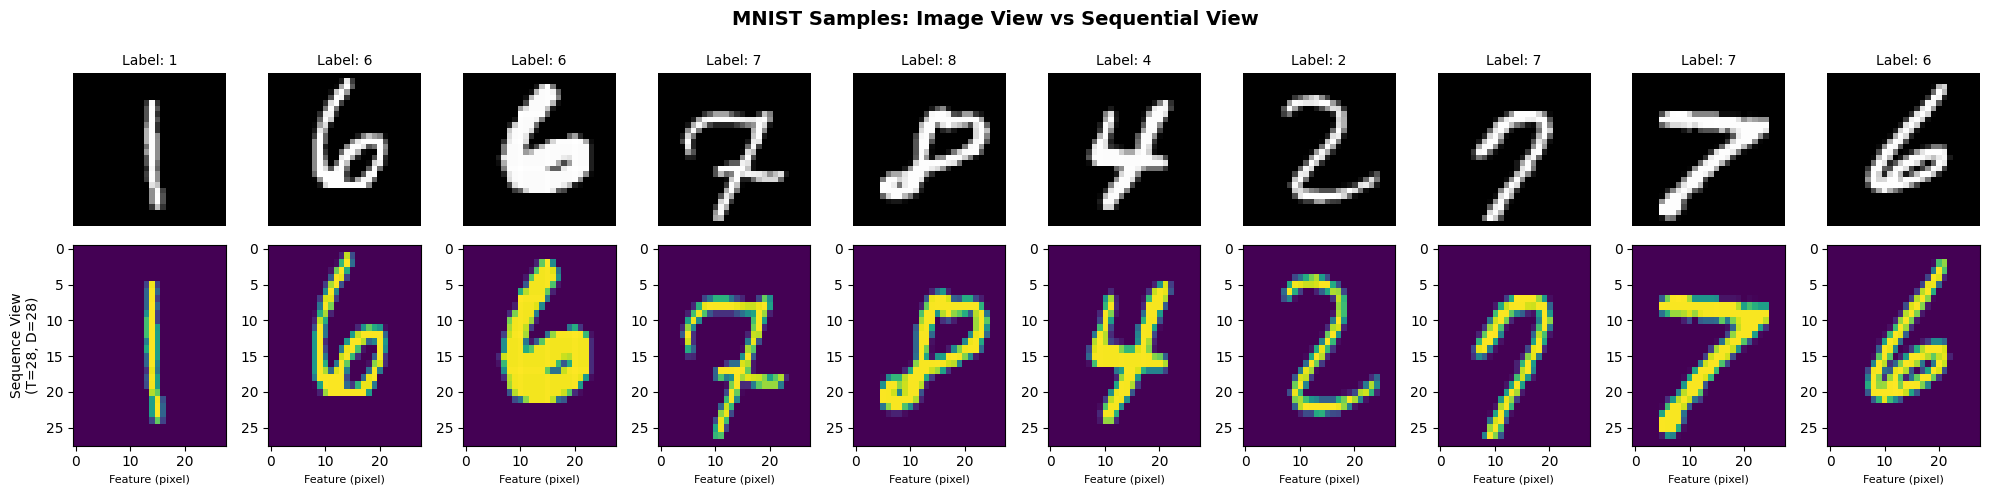

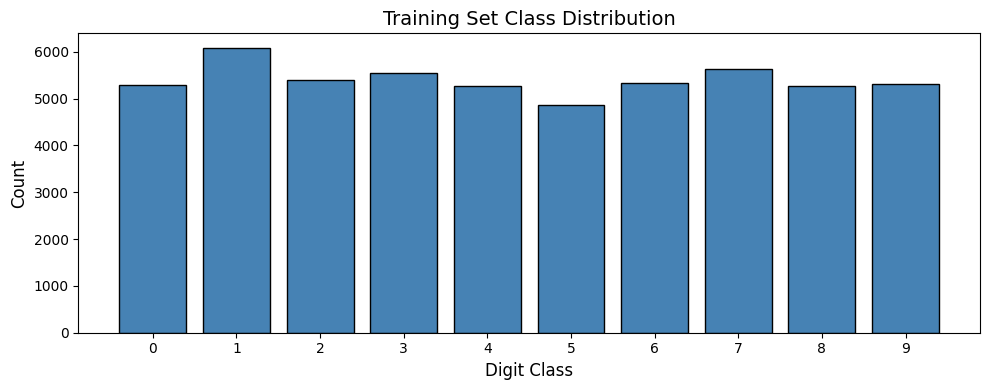

In [4]:
def visualize_mnist_samples(data_path, n_samples=10):
    """Visualize MNIST samples and their sequential representation."""
    
    with h5py.File(data_path, 'r') as f:
        images = np.array(f['train']['data'][:n_samples])
        labels = np.array(f['train']['labels'][:n_samples])
    
    fig, axes = plt.subplots(2, n_samples, figsize=(2*n_samples, 5))
    fig.suptitle('MNIST Samples: Image View vs Sequential View', fontsize=14, fontweight='bold')
    
    for i in range(n_samples):
        # Top row: Original image view
        axes[0, i].imshow(images[i], cmap='gray')
        axes[0, i].set_title(f'Label: {labels[i]}', fontsize=10)
        axes[0, i].axis('off')
        
        # Bottom row: Sequential view (heatmap of 28 timesteps x 28 features)
        im = axes[1, i].imshow(images[i], cmap='viridis', aspect='auto')
        axes[1, i].set_xlabel('Feature (pixel)', fontsize=8)
        if i == 0:
            axes[1, i].set_ylabel('Time (row)', fontsize=8)
    
    axes[0, 0].set_ylabel('Image View', fontsize=10)
    axes[1, 0].set_ylabel('Sequence View\n(T=28, D=28)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Show class distribution
    with h5py.File(data_path, 'r') as f:
        all_labels = np.array(f['train']['labels'])
    
    fig, ax = plt.subplots(figsize=(10, 4))
    counts = np.bincount(all_labels)
    ax.bar(range(10), counts, color='steelblue', edgecolor='black')
    ax.set_xlabel('Digit Class', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Training Set Class Distribution', fontsize=14)
    ax.set_xticks(range(10))
    plt.tight_layout()
    plt.show()

visualize_mnist_samples(data_path)

## 3. Examine the Model Architecture

Let's look at the SOEN model we'll be training.

In [5]:
from soen_toolkit.core.model_yaml import build_model_from_yaml

# Load and inspect the model
model_path = Path("training/test_models/model_specs/MNIST_SOENSpec.yaml")
model = build_model_from_yaml(model_path)

print("=" * 60)
print("MNIST SOEN MODEL ARCHITECTURE")
print("=" * 60)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\nLayer dimensions:")
for layer_id, dim in model.layer_nodes.items():
    print(f"  Layer {layer_id}: {dim} neurons")

print("\nConnections:")
for name, param in model.connections.items():
    print(f"  {name}: {param.shape} (learnable: {param.requires_grad})")

# Test forward pass
print("\nTesting forward pass...")
x_test = torch.randn(2, 28, 28)  # [batch=2, seq_len=28, features=28]
with torch.no_grad():
    output, states = model(x_test)
print(f"  Input shape: {x_test.shape}")
print(f"  Output shape: {output.shape}")
print("  Forward pass successful!")

MNIST SOEN MODEL ARCHITECTURE

Total parameters: 21,760
Trainable parameters: 21,248

Layer dimensions:
  Layer 0: 28 neurons
  Layer 1: 128 neurons
  Layer 2: 10 neurons

Connections:
  J_0_to_1: torch.Size([128, 28]) (learnable: True)
  J_1_to_1: torch.Size([128, 128]) (learnable: True)
  J_1_to_2: torch.Size([10, 128]) (learnable: True)

Testing forward pass...
  Input shape: torch.Size([2, 28, 28])
  Output shape: torch.Size([2, 29, 10])
  Forward pass successful!


## 4. Train the Model

Now let's train the SOEN model on MNIST using the training configuration.

In [6]:
# Disable progress bar to avoid widget errors in notebooks
import os
os.environ["SOEN_NO_PROGRESS_BAR"] = "1"

from soen_toolkit.training.trainers.experiment import run_from_config

# Run training
print("Starting MNIST SOEN training...")
print("This may take a while depending on your hardware.")
print("="*60)

run_from_config("training/training_configs/mnist_soen.yaml", script_dir=Path.cwd())

Seed set to 42


Starting MNIST SOEN training...
This may take a while depending on your hardware.

All logs are being written to: /home/idies/workspace/Temporary/dpark1/scratch/SOEN/soenre/src/soen_toolkit/tutorial_notebooks/training/temp/project_MNIST_SOEN/experiment_MNIST_SingleDendrite_128/group_MNIST/logs/repeat_0_20260120_221145/experiment_run_repeat_0_20260120_221145.log



Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



🚀 SOEN TRAINING SUMMARY
📋 Project Name:      MNIST_SOEN
🧪 Experiment Name:   MNIST_SingleDendrite_128
👥 Group Name:        MNIST
🔢 Repeat:            1/1
🎲 Seed:              42

⚙️  TRAINING CONFIGURATION
   • Max Epochs:      30
   • Batch Size:      64
   • Optimizer:       adam
   • Learning Rate:   0.001
   • Accelerator:     auto
   • Devices:         auto
   • Precision:       32-true

📊 DATA CONFIGURATION
   • Dataset Path:    training/datasets/mnist_seq28.hdf5
   • Num Classes:     10
   • Val Split:       0.2
   • Test Split:      0.1

🧠 MODEL CONFIGURATION
   • Base Model:      training/test_models/model_specs/MNIST_SOENSpec.yaml
   • Backend:         torch
   • Time Pooling:    {'name': 'max', 'params': {'scale': 1.0}}

📁 PATHS & LOGGING
   • Checkpoints:     /home/idies/workspace/Temporary/dpark1/scratch/SOEN/soenre/src/soen_toolkit/tutorial_notebooks/training/temp/project_MNIST_SOEN/experiment_MNIST_SingleDendrite_128/group_MNIST/checkpoints/repeat_0_20260120_221145
   •

Loading `train_dataloader` to estimate number of stepping batches.
[Cosine] Determined batches_per_epoch: 844
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | SOENModelCore | 21.8 K | train
------------------------------------------------
21.2 K    Trainable params
512       Non-trainable params
21.8 K    Total params
0.087     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
[PyTorch] CUDA available: True
[PyTorch] GPU devices: 4
[PyTorch]   GPU 0: NVIDIA H100 80GB HBM3
[PyTorch]   GPU 1: NVIDIA H100 80GB HBM3
[PyTorch]   GPU 2: NVIDIA H100 80GB HBM3
[PyTorch]   GPU 3: NVIDIA H100 80GB HBM3


  [Epoch 1] Validation | val_loss: 2.4156 | val_accuracy: N/A

[Epoch 1/30] Starting training (844 batches)...
  [Step 100] loss: 2.2941
  [Step 200] loss: 2.0995
  [Step 300] loss: 2.0116
  [Step 400] loss: 1.7547
  [Step 500] loss: 1.5745
  [Step 600] loss: 1.3632
  [Step 700] loss: 1.0659
  [Step 800] loss: 0.8658
  [Epoch 1] Validation | val_loss: 0.7918 | val_accuracy: N/A
  [Epoch 1] Train complete in 24.0s | train_loss: 1.6400

[Epoch 2/30] Starting training (844 batches)...
  [Step 100] loss: 0.6429
  [Step 200] loss: 0.6053
  [Step 300] loss: 0.4248
  [Step 400] loss: 0.5042
  [Step 500] loss: 0.5606
  [Step 600] loss: 0.4493
  [Step 700] loss: 0.3359
  [Step 800] loss: 0.1617
  [Epoch 2] Validation | val_loss: 0.3957 | val_accuracy: 0.8340
  [Epoch 2] Train complete in 27.5s | train_loss: 0.5024

[Epoch 3/30] Starting training (844 batches)...
  [Step 100] loss: 0.4079
  [Step 200] loss: 0.2706
  [Step 300] loss: 0.2629
  [Step 400] loss: 0.3200
  [Step 500] loss: 0.3207
  [S

`Trainer.fit` stopped: `max_epochs=30` reached.



TRAINING COMPLETE

Final Metrics:
   Training:
      train_loss/cross_entropy: 0.051613
      train_loss/cross_entropy_step: 0.015267
      train_loss/total: 0.051613
      train_loss/total_step: 0.015267
      train_loss/cross_entropy_epoch: 0.051613
      train_loss/total_epoch: 0.051613
   Validation:
      val_loss/cross_entropy: 0.068736
      val_loss/total: 0.068736
      val_accuracy: 0.979833
      val_perplexity: 1.071153
   Other:
      lr-Adam: 0.000021
      input_seq_len: 28.000000
      callbacks/learning_rate: 0.000021

Total Training Time: 14m 47s

Best Checkpoint: /home/idies/workspace/Temporary/dpark1/scratch/SOEN/soenre/src/soen_toolkit/tutorial_notebooks/training/temp/project_MNIST_SOEN/experiment_MNIST_SingleDendrite_128/group_MNIST/checkpoints/repeat_0_20260120_221145/model-epoch=27-val_loss/total=0.0684.ckpt



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9785999655723572     │
│  test_loss/cross_entropy  │    0.06958901882171631    │
│      test_loss/total      │    0.06958901882171631    │
│      test_perplexity      │    1.0720674991607666     │
└───────────────────────────┴───────────────────────────┘

## 5. Evaluate the Trained Model

Let's load the best checkpoint and evaluate on the test set.

In [7]:
def load_best_checkpoint():
    """Find and load the best checkpoint from training."""
    
    # Find checkpoints
    ckpt_patterns = [
        "training/temp/**/checkpoints/**/*.ckpt",
        "training/temp/**/*.ckpt",
    ]
    
    all_ckpts = []
    for pattern in ckpt_patterns:
        all_ckpts.extend(glob.glob(pattern, recursive=True))
    
    if not all_ckpts:
        print("No checkpoint found. Run training first.")
        return None, None
    
    # Get the most recent checkpoint
    latest_ckpt = max(all_ckpts, key=lambda x: Path(x).stat().st_mtime)
    print(f"Loading checkpoint: {latest_ckpt}")
    
    # Load model
    model_path = Path("training/test_models/model_specs/MNIST_SOENSpec.yaml")
    model = build_model_from_yaml(model_path)
    
    # Load weights
    ckpt = torch.load(latest_ckpt, map_location='cpu')
    state_dict = ckpt.get('state_dict', ckpt)
    
    # Remove 'model.' prefix if present
    clean_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('model.'):
            clean_state_dict[k[6:]] = v
        else:
            clean_state_dict[k] = v
    
    model.load_state_dict(clean_state_dict, strict=False)
    model.eval()
    
    return model, latest_ckpt

trained_model, ckpt_path = load_best_checkpoint()

Loading checkpoint: training/temp/project_MNIST_SOEN/experiment_MNIST_SingleDendrite_128/group_MNIST/checkpoints/repeat_0_20260120_221145/last.ckpt


In [8]:
def evaluate_on_test_set(model, data_path, batch_size=128):
    """Evaluate model on the test set."""
    
    if model is None:
        print("No model loaded.")
        return
    
    # Load test data
    with h5py.File(data_path, 'r') as f:
        test_data = np.array(f['test']['data'])
        test_labels = np.array(f['test']['labels'])
    
    print(f"Evaluating on {len(test_labels)} test samples...")
    
    model.eval()
    device = next(model.parameters()).device
    
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(test_data), batch_size)):
            batch_data = test_data[i:i+batch_size]
            x = torch.tensor(batch_data, dtype=torch.float32).to(device)
            
            output, _ = model(x)
            
            # Apply max pooling over time
            if output.dim() == 3:
                pooled = output.max(dim=1)[0]
            else:
                pooled = output
            
            probs = torch.softmax(pooled, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    
    # Calculate accuracy
    accuracy = (all_preds == test_labels).mean()
    
    print(f"\n{'='*50}")
    print(f"TEST SET RESULTS")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Correct: {(all_preds == test_labels).sum()}/{len(test_labels)}")
    
    return all_preds, all_probs, accuracy

if trained_model is not None:
    predictions, probabilities, test_accuracy = evaluate_on_test_set(trained_model, data_path)

Evaluating on 10000 test samples...

TEST SET RESULTS
Accuracy: 0.9773 (97.73%)
Correct: 9773/10000


## 6. Visualize Predictions

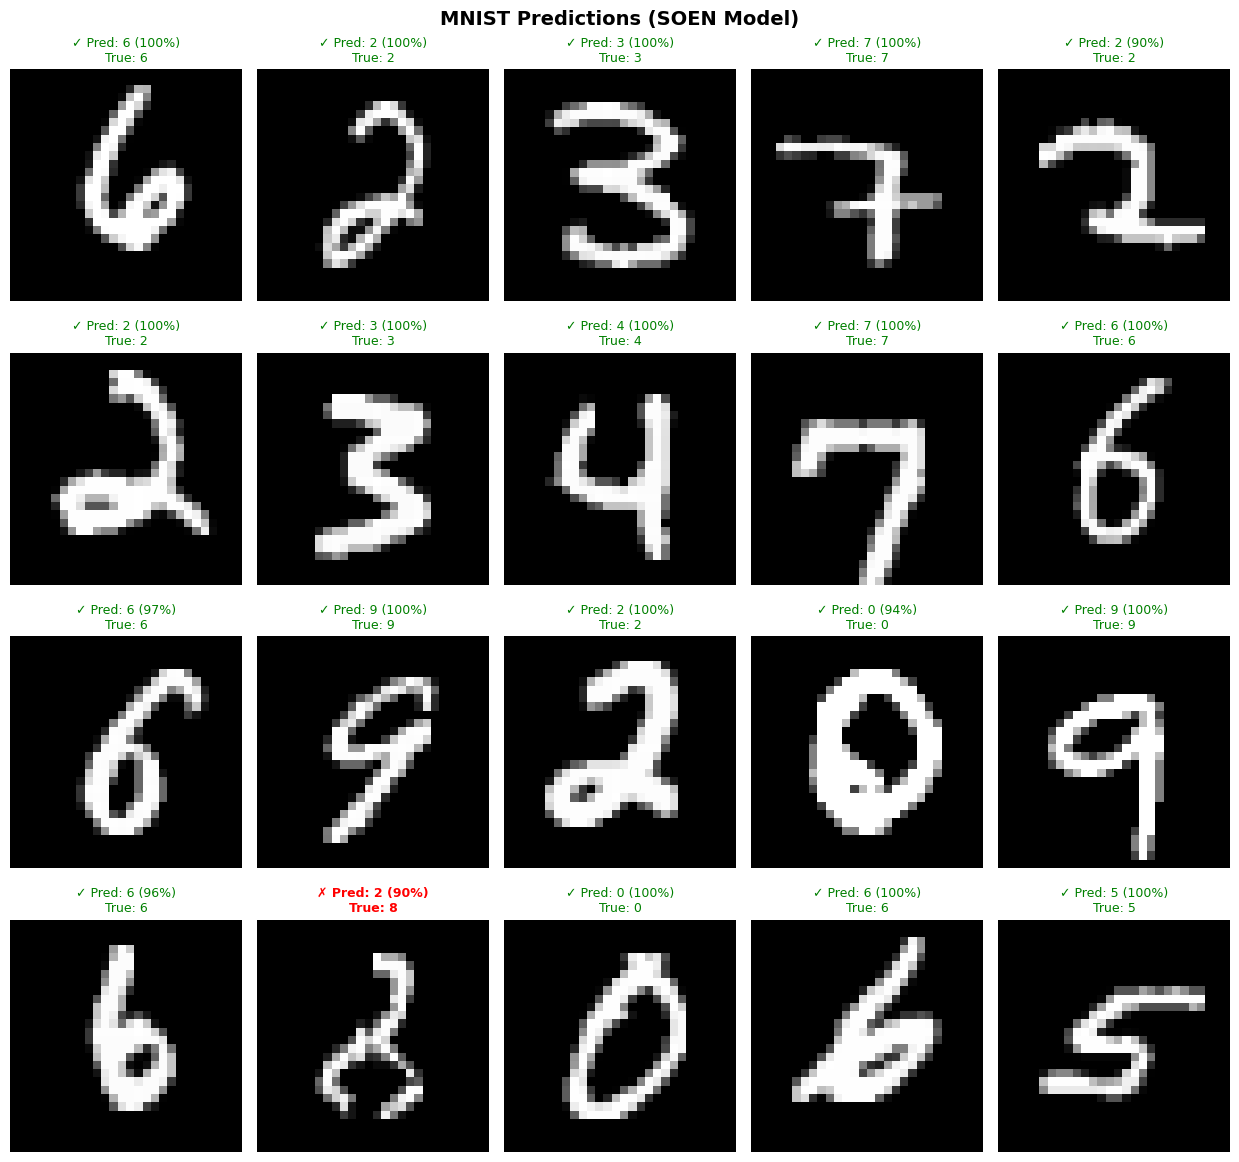


Sample accuracy: 95.0% (19/20)


In [9]:
def visualize_predictions(model, data_path, n_samples=20):
    """Visualize model predictions on random test samples."""
    
    if model is None:
        print("No model loaded.")
        return
    
    # Load test data
    with h5py.File(data_path, 'r') as f:
        test_data = np.array(f['test']['data'])
        test_labels = np.array(f['test']['labels'])
    
    # Random sample
    np.random.seed(42)
    indices = np.random.choice(len(test_data), n_samples, replace=False)
    
    samples = test_data[indices]
    labels = test_labels[indices]
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        x = torch.tensor(samples, dtype=torch.float32)
        output, _ = model(x)
        
        if output.dim() == 3:
            pooled = output.max(dim=1)[0]
        else:
            pooled = output
        
        probs = torch.softmax(pooled, dim=1)
        preds = torch.argmax(probs, dim=1).numpy()
        confidence = probs.max(dim=1)[0].numpy()
    
    # Plot
    n_cols = 5
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5*n_cols, 3*n_rows))
    axes = axes.flatten()
    
    fig.suptitle('MNIST Predictions (SOEN Model)', fontsize=14, fontweight='bold')
    
    for i in range(n_samples):
        ax = axes[i]
        ax.imshow(samples[i], cmap='gray')
        
        is_correct = preds[i] == labels[i]
        color = 'green' if is_correct else 'red'
        symbol = '✓' if is_correct else '✗'
        
        ax.set_title(
            f"{symbol} Pred: {preds[i]} ({confidence[i]:.0%})\nTrue: {labels[i]}",
            fontsize=9,
            color=color,
            fontweight='bold' if not is_correct else 'normal'
        )
        ax.axis('off')
    
    # Hide empty subplots
    for i in range(n_samples, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    accuracy = (preds == labels).mean()
    print(f"\nSample accuracy: {accuracy:.1%} ({(preds == labels).sum()}/{n_samples})")

if trained_model is not None:
    visualize_predictions(trained_model, data_path)

## 7. Confusion Matrix

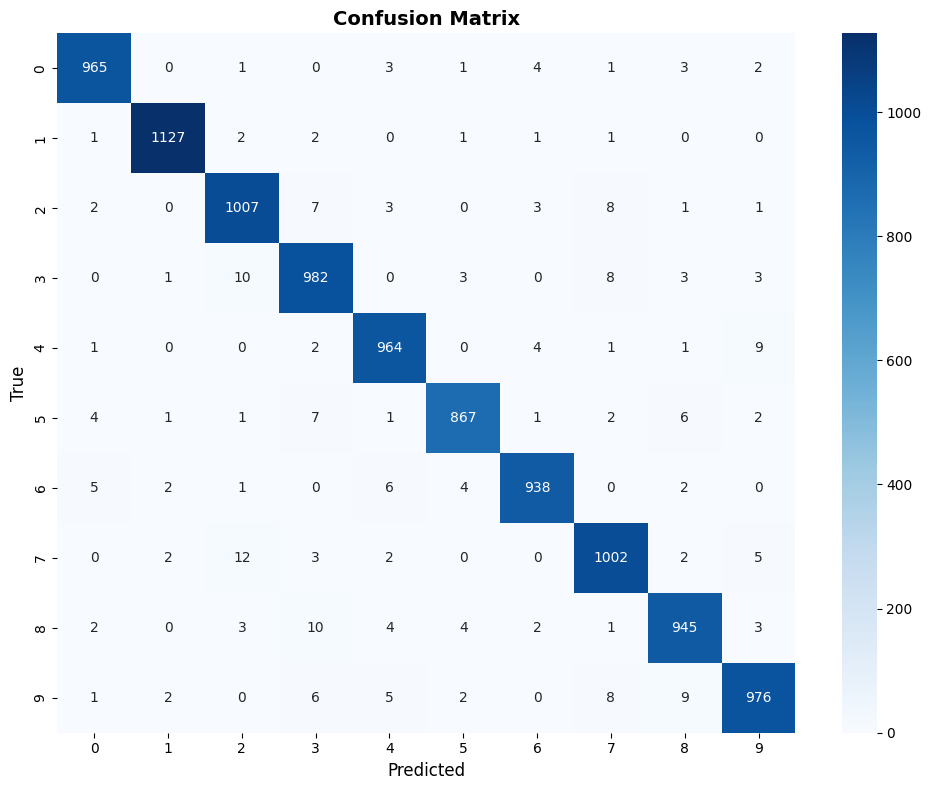


Per-class accuracy:
  Digit 0: 98.5%
  Digit 1: 99.3%
  Digit 2: 97.6%
  Digit 3: 97.2%
  Digit 4: 98.2%
  Digit 5: 97.2%
  Digit 6: 97.9%
  Digit 7: 97.5%
  Digit 8: 97.0%
  Digit 9: 96.7%


In [10]:
def plot_confusion_matrix(predictions, true_labels):
    """Plot confusion matrix for predictions."""
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(true_labels, predictions)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=range(10), yticklabels=range(10))
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy
    print("\nPer-class accuracy:")
    for digit in range(10):
        mask = true_labels == digit
        class_acc = (predictions[mask] == digit).mean()
        print(f"  Digit {digit}: {class_acc:.1%}")

if trained_model is not None:
    with h5py.File(data_path, 'r') as f:
        test_labels = np.array(f['test']['labels'])
    plot_confusion_matrix(predictions, test_labels)

## 8. Analyze SOEN Dynamics

Let's visualize how the SingleDendrite layer processes the input over time.

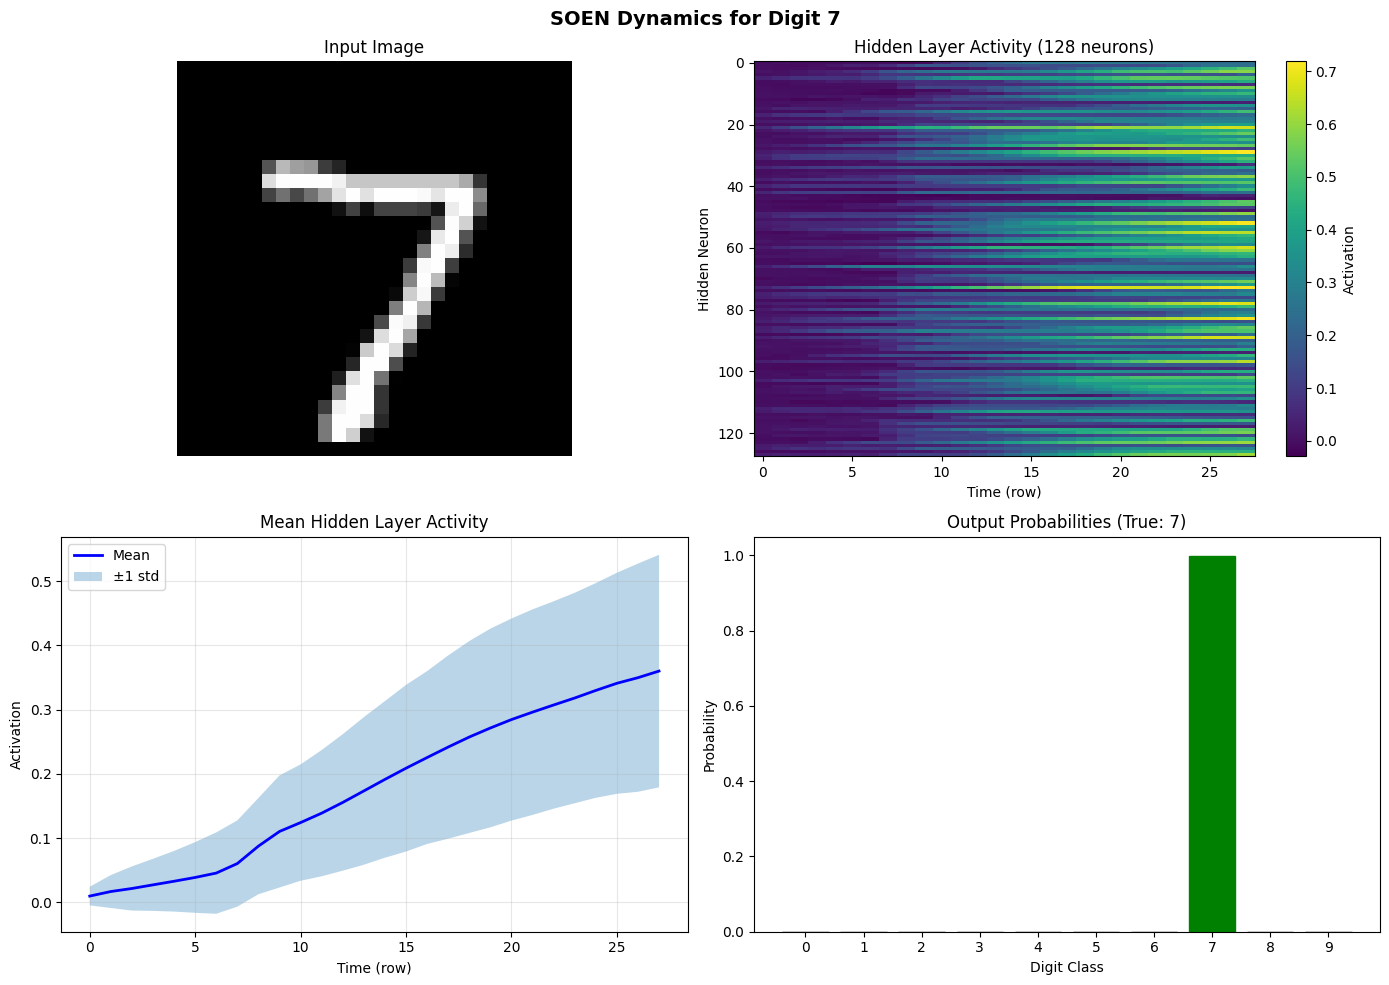

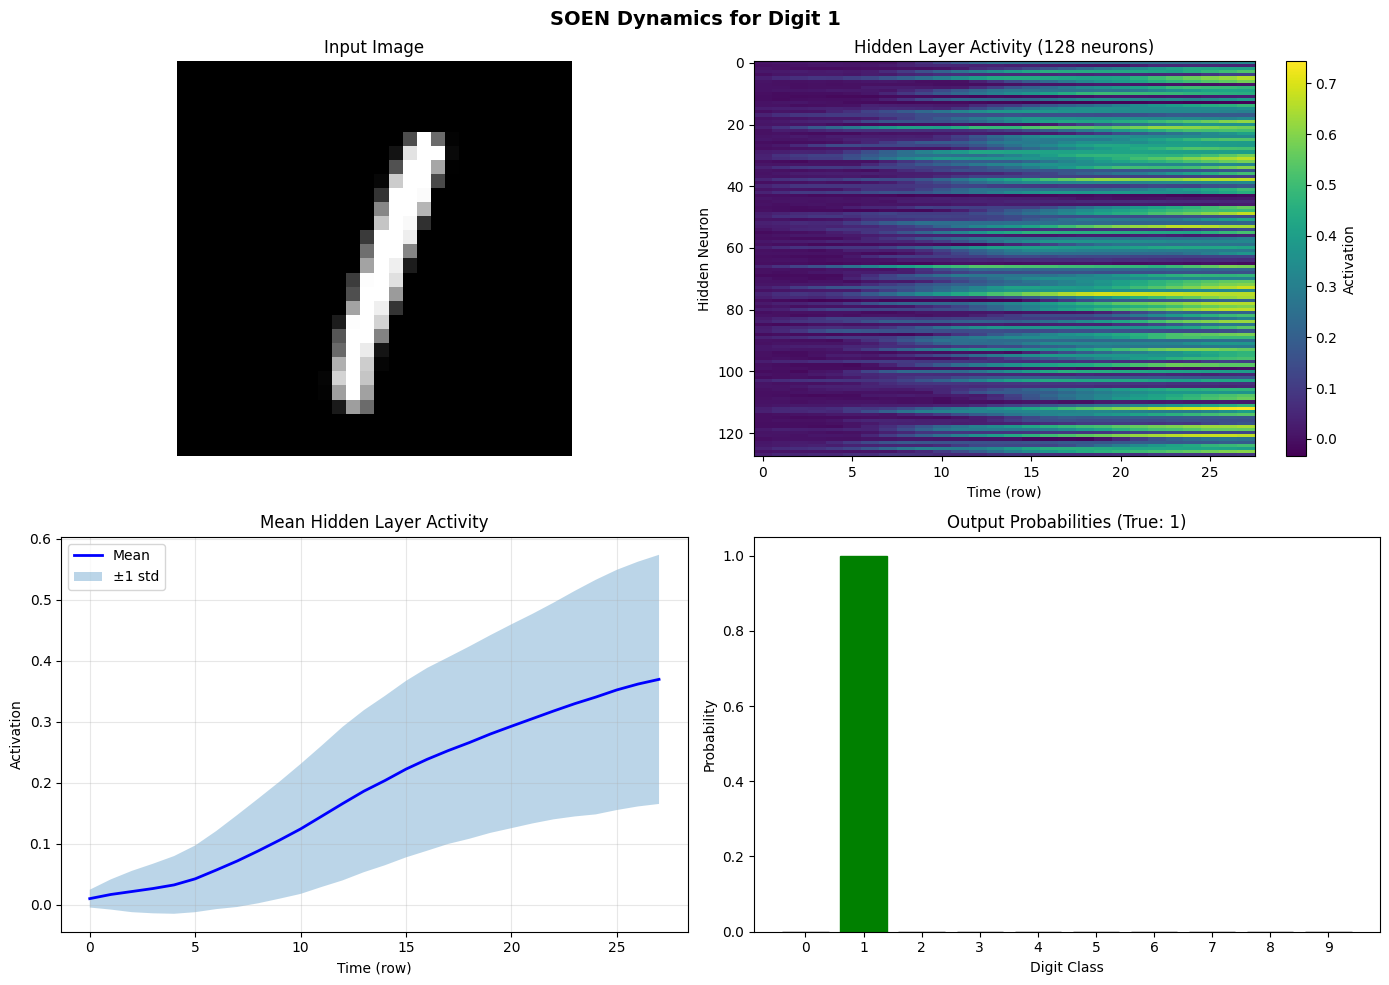

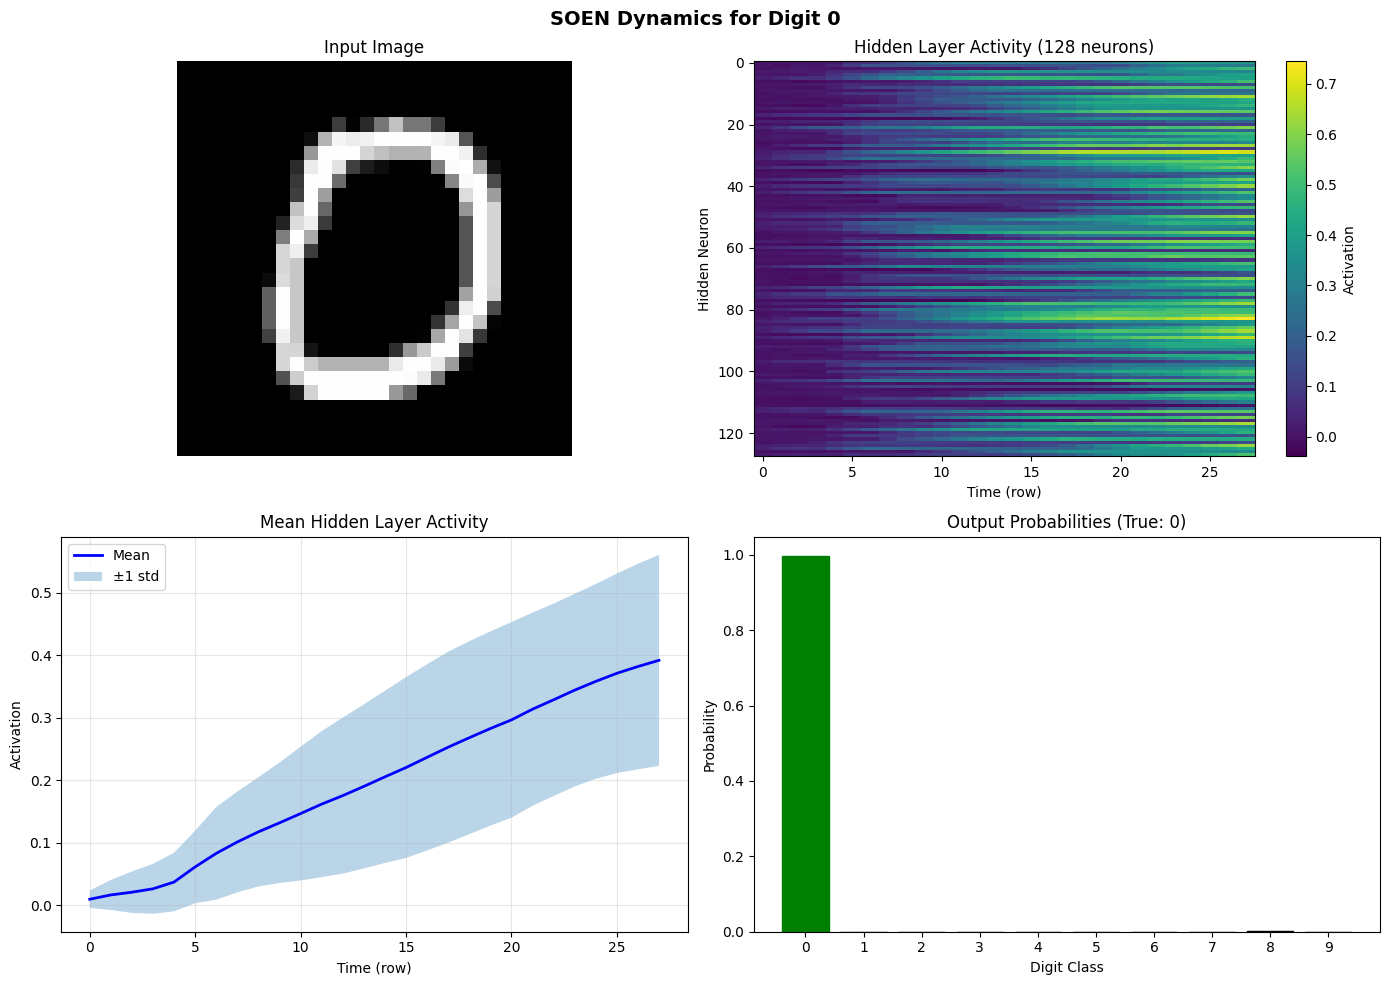

In [11]:
def visualize_soen_dynamics(model, data_path, sample_idx=0):
    """Visualize the temporal dynamics of the SOEN hidden layer."""
    
    if model is None:
        print("No model loaded.")
        return
    
    # Load a sample
    with h5py.File(data_path, 'r') as f:
        sample = np.array(f['test']['data'][sample_idx:sample_idx+1])
        label = np.array(f['test']['labels'][sample_idx])
    
    model.eval()
    
    with torch.no_grad():
        x = torch.tensor(sample, dtype=torch.float32)
        output, all_states = model(x)
        
        # Get hidden layer states (Layer 1)
        hidden_states = all_states[1]  # [batch, seq_len+1, hidden_dim]
        hidden_states = hidden_states[0, 1:, :].numpy()  # Remove batch and initial state
        
        # Get output
        if output.dim() == 3:
            output_over_time = output[0].numpy()
        else:
            output_over_time = output[0].numpy()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'SOEN Dynamics for Digit {label}', fontsize=14, fontweight='bold')
    
    # 1. Input image
    axes[0, 0].imshow(sample[0], cmap='gray')
    axes[0, 0].set_title('Input Image', fontsize=12)
    axes[0, 0].axis('off')
    
    # 2. Hidden layer activity over time
    im = axes[0, 1].imshow(hidden_states.T, aspect='auto', cmap='viridis')
    axes[0, 1].set_xlabel('Time (row)', fontsize=10)
    axes[0, 1].set_ylabel('Hidden Neuron', fontsize=10)
    axes[0, 1].set_title('Hidden Layer Activity (128 neurons)', fontsize=12)
    plt.colorbar(im, ax=axes[0, 1], label='Activation')
    
    # 3. Mean hidden activity over time
    mean_activity = hidden_states.mean(axis=1)
    std_activity = hidden_states.std(axis=1)
    time_steps = np.arange(len(mean_activity))
    axes[1, 0].plot(time_steps, mean_activity, 'b-', linewidth=2, label='Mean')
    axes[1, 0].fill_between(time_steps, 
                            mean_activity - std_activity,
                            mean_activity + std_activity,
                            alpha=0.3, label='±1 std')
    axes[1, 0].set_xlabel('Time (row)', fontsize=10)
    axes[1, 0].set_ylabel('Activation', fontsize=10)
    axes[1, 0].set_title('Mean Hidden Layer Activity', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Output class probabilities at final timestep
    if output_over_time.ndim == 2:
        final_output = output_over_time[-1]
    else:
        final_output = output_over_time
    probs = np.exp(final_output) / np.exp(final_output).sum()  # Softmax
    
    bars = axes[1, 1].bar(range(10), probs, color='steelblue', edgecolor='black')
    bars[label].set_color('green')  # Highlight true class
    axes[1, 1].set_xlabel('Digit Class', fontsize=10)
    axes[1, 1].set_ylabel('Probability', fontsize=10)
    axes[1, 1].set_title(f'Output Probabilities (True: {label})', fontsize=12)
    axes[1, 1].set_xticks(range(10))
    
    plt.tight_layout()
    plt.show()

if trained_model is not None:
    # Visualize dynamics for a few samples
    for idx in [0, 5, 10]:
        visualize_soen_dynamics(trained_model, data_path, sample_idx=idx)

## Summary

In this tutorial, we:

1. **Prepared MNIST** as a sequential dataset (28 timesteps × 28 features)
2. **Built a SOEN model** with:
   - Input layer (28D)
   - SingleDendrite hidden layer (128D) with recurrent connections
   - Linear output layer (10D) with **learnable** connections
3. **Trained the model** using the SOEN training pipeline
4. **Evaluated and visualized** the results

### Key Takeaways

- SOEN networks naturally process sequential data through temporal integration
- The SingleDendrite layer accumulates evidence over time (each row of the image)
- **Learnable output connections** are critical for effective training (from Tutorial 02)
- The recurrent connections allow the network to maintain context across timesteps

### Next Steps

- Try different hidden layer sizes (64, 256, 512)
- Experiment with multiple hidden layers
- Adjust the temporal parameters (gamma_plus, gamma_minus, dt)
- Compare with traditional RNN/LSTM baselines